In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

# Convolutions

Convolutions are a special kind of linear transformations. For each patch of neighboring pixels in an image, a convolution outputs a linear combination of the pixel values with the weights of the convolution filter *kernel*. Each of these outputs again represents a pixel value of the output image. One convolution kernel is of patch size $h \times w$. As we want one kernel for each input and output channel, the weights for a convolution layer are actually of size $C_{out} \times C_{in} \times h \times w$.

There are three properties which make convolutions very powerful:
- **parameter sharing:** The same parameters of the kernel are used in each patch of the image. This simplifies the model and additionally leads to a more faithful gradient on the weights.
- **locality:** The shape of the patches makes sure that we only use information from pixels located in the close neighborhood.
- **translational invariance:** No matter, on which patch we apply the convolution kernel, the weights stay the same and therefore the behaviour is independent of the absolute position of the patch in the image.

# Cross-correlation vs. Convolutions

In the context of Deep Learning people often refer to discrete cross-correlation as convolutions. In PyTorch the `torch.nn.Conv2d` module takes inputs of the size $C_{\text{in}} \times H \times W$ and calculates the discrete ross-correlation w.r.t. a kernel of size $C_{\text{out}} \times C_{\text{in}} \times h \times w$ to produce an output of size $C_{\text{out}} \times H' \times W'$. The spatial size of the output $H'$, $W'$ depends on the kernel size as well as on the padding and the stride values. For the case of no padding and stride the output values $z$ for input $x$ and kernel $k$ are calculated as
\begin{align}
z_{c, i, j} = \sum_{l=1}^{C_{\text{in}}} \sum_{m=0}^{h-1} \sum_{n=0}^{w-1} x_{l,i+m,j+n} \cdot k_{c,l,m+1,n+1}.
\end{align}
For the sake of notational simplicity we will use the term *'convolution'* in the following even though we actually mean cross-correlation.

# Convolutions in classical image processing task

The following tasks comprise a series of classical applications of convolutions and should give an impression of the their versatility and expressivenes.

## Edge detector [2 points]

We can implement a simple edge detector by approximating derivatives with Taylor's expansion formula and calculating the finite differences with a kernel filter. For an image pixel $u_{i,j}$ calculate the derivates $(u_x)_{i,j}$ as $u_{i,j+1}-u_{i,j}$ and $(u_y)_{i,j}$ as $u_{i+1,j}-u_{i,j}$ using dedicated convolution kernels.

torch.Size([1, 1, 321, 481])


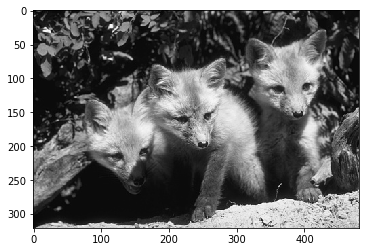

In [2]:
from torchvision.transforms.functional import to_tensor, to_grayscale
from PIL import Image
im_gray = to_tensor(to_grayscale(Image.open('foxes.png')))
im_gray = im_gray[None, ...]
print(im_gray.shape)
plt.imshow(im_gray[0, 0], cmap='gray', vmin=0., vmax=1.)

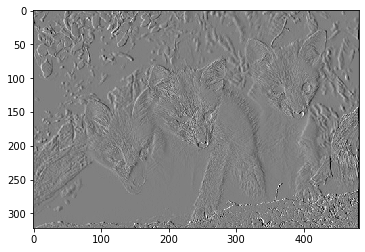

In [3]:
########################################
# Set the values of the kernel in ker_x

ker_x = [[-1, 1], [0, 0]]
ker_x = torch.tensor(ker_x).float()
ker_x = ker_x[None, None, :, :]

########################################

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2, 2), padding=(1, 1), bias=False)
conv.weight.data = ker_x

with torch.no_grad():
    res = conv(im_gray)

plt.imshow(res[0, 0], cmap='gray', vmin=-0.5, vmax=0.5)
torch.save(ker_x, 'ker_x')

torch.Size([1, 1, 322, 482])


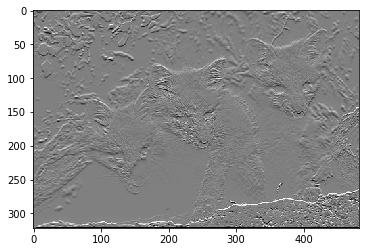

In [4]:
########################################
# Set the values of the kernel in ker_y

ker_y = [[-1, 0], [1, 0]]
ker_y = torch.tensor(ker_y).float()
ker_y = ker_y[None, None, :, :]

########################################

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2, 2), padding=(1, 1), bias=False)
conv.weight.data = ker_y

with torch.no_grad():
    res = conv(im_gray)
print (res.shape)
plt.imshow(res[0, 0], cmap='gray', vmin=-0.5, vmax=0.5)
torch.save(ker_y, 'ker_y')

## Gaussian Blur Kernel [3 points]

A common method for removing noise from an image is applying a Gauss filter https://en.wikipedia.org/wiki/Gaussian_filter. Identifying the length of a pixel as one and setting $\sigma$ to 1, discretely approximate the Gauss kernel. Normalize your kernel's weights such that they sum up to $1$.

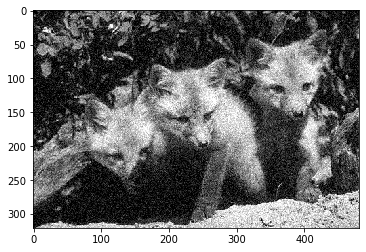

In [5]:
im_noisy = im_gray + torch.randn_like(im_gray) * 25./255.

plt.imshow(im_noisy[0, 0], cmap='gray', vmin=0., vmax=1.)

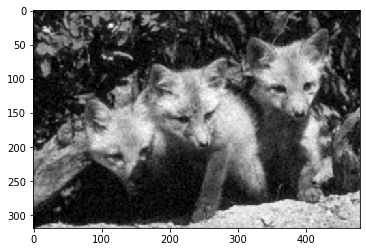

In [6]:
###########################################
# Set the values of the kernel in ker_gauss
# The spatial patch size is 5x5


sz = 2

lin = torch.linspace(-sz, sz, 2*sz+1)

x = lin
y = lin[..., None]

d = x ** 2 + y ** 2

ker_gauss = torch.exp(-(1./2) * d)
ker_gauss /= ker_gauss.sum()
ker_gauss = ker_gauss[None, None, :]
###########################################

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 5), padding=(1, 1), bias=False)
conv.weight.data = ker_gauss

with torch.no_grad():
    res = conv(im_noisy)

plt.imshow(res[0, 0], cmap='gray', vmin=0.0, vmax=1.0)
torch.save(ker_gauss, 'ker_gauss')

# Convolution implementation [6 points]

Implement a $2$-D convolution in `modules.py` and test your code below. Do not use pre-implemented code for calculating convolutions.

In [7]:
from modules import Conv2d

In [8]:
x = torch.randn(1, 3, 6, 8)
kernel = torch.randn(2, 3, 4, 5)

conv = Conv2d(kernel, padding=1, stride=3)
res = conv(x[0])
print(res.shape)

conv_gt = nn.Conv2d(3, 2, (4, 5), padding=1, stride=3, bias=False)
conv_gt.weight.data = kernel

print (conv_gt(x)[0].shape)
print (conv_gt(x).shape)
with torch.no_grad():
    res_gt = conv_gt(x)[0]

torch.Size([2, 2, 2])
torch.Size([2, 2, 2])
torch.Size([1, 2, 2, 2])


In [9]:
x = torch.ones(1,3,5,5)
kernel = torch.ones(2, 3, 3, 3)*2

conv = Conv2d(kernel, padding=1, stride=3)
res = conv(x[0])
print(res)

conv_gt = nn.Conv2d(3, 2, (3, 3), padding=1, stride=3, bias=False)
conv_gt.weight.data = kernel
print (conv_gt(x)[0].shape)
print (conv_gt(x)[0])

with torch.no_grad():
    res_gt = conv_gt(x)[0]


tensor([[[24., 36.],
         [36., 54.]],

        [[24., 36.],
         [36., 54.]]])
torch.Size([2, 2, 2])
tensor([[[24., 36.],
         [36., 54.]],

        [[24., 36.],
         [36., 54.]]], grad_fn=<SelectBackward>)


In [10]:
assert (res_gt - res).abs().max() < 1e-5